layerNorm 和 batch Norm

Norm 的目标就是 均值为0，方差为1

LayerNorm 是针对样本的，对每个样本的所有特征进行归一化。
    不依赖Batch，在单个样本内部，
    适合RNN、Transformer、LLM:序列的长度变化、batch可能很小或者需要分布式切片时尤其重要！
    不会把不同的样本混在一起
    样本内特征维度归一化，统计量不跨batch，训练、推理一致，对小batch/序列模型友好
batchNorm 是特征粒度，遍历所有样本，在批次内进行归一化。
    按照“通道”归一化，统计量跨batch；推理时可以使用训练时的累积值；batch小时容易不稳定。
Ln 的输入和输出的shape 是保持不变的



在NLP问题中，送给Layer Norm 的输入是 embedding ，

token embedding + position embedding (+ segment embedding) 
-> LayerNorm -> Dropout -> Transformer Blocks

举例
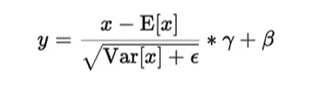
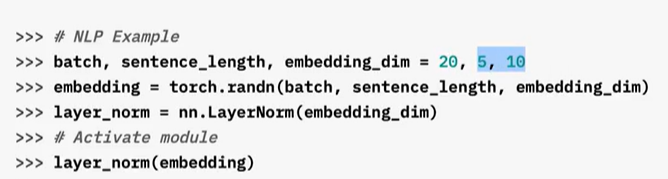
LM的参数 是从尾部开始，在这里可以可以是[10]，也可以是[5,10] last Dimensions
20：一个batch 有20个样本/句子
5：序列长度：每个样本里面5个token
10：每个token的embedding维度是10，长度为10的向量

如果是[10]，就是对最后一个维度10做归一化
它会对每个位置 (n, t) 的向量 embedding[n, t, :] 单独计算均值和方差，然后归一化。不跨 token、不跨 batch
如果是[5,10] 一般不这样
就是会针对每个样本，在[5,10]这个二维矩阵内部同一的去做归一化，即会跨token的去做，每个样本作为一个整体。
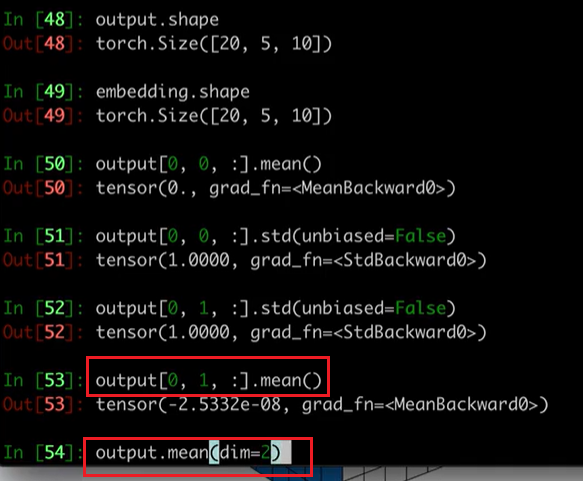


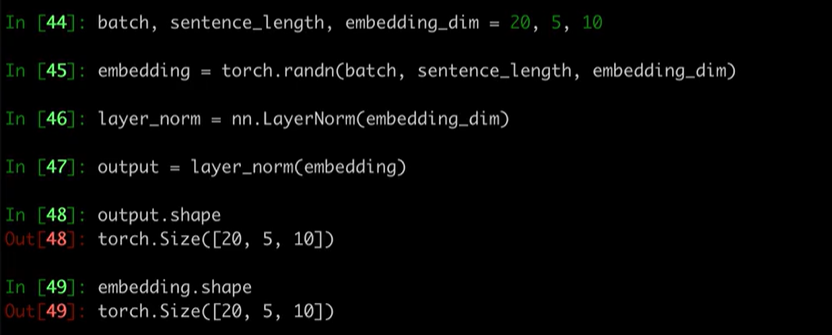
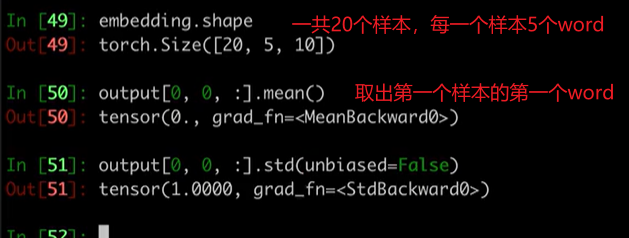

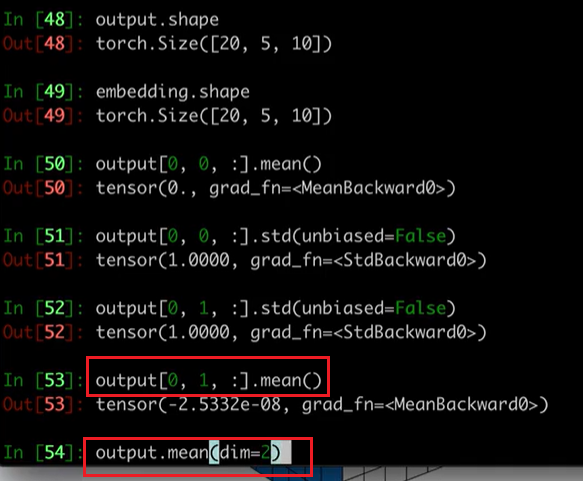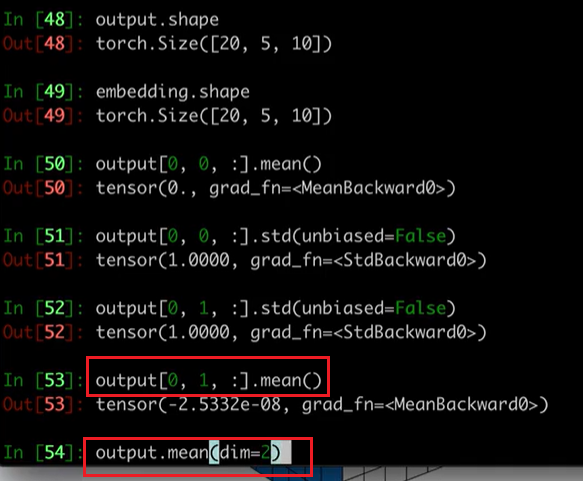

两者算的维度范围不同，因此输出形状也不同。

假设 output.shape == (20, 5, 10)，对应 (batch, seq_len, embed_dim)。

① output[0, 1, :].mean()
先用索引固定：第 0 个样本、第 1 个 token，只剩一个长度为 10 的向量 output[0,1,:]（shape (10,)）
再对这 10 个数求均值
结果是一个标量（shape ()）
等价于：只算某一个 token 的 embedding 维均值。

② output.mean(dim=2)
不固定 batch 和 token，对所有位置都算
指定 dim=2：沿着最后一维 embed_dim=10 求均值
结果是一个矩阵（shape (20, 5)），其中每个元素是对应 (n,t) 的 output[n,t,:] 的均值
等价于：对每个样本的每个 token分别算 embedding 维均值，一次性全算出来。

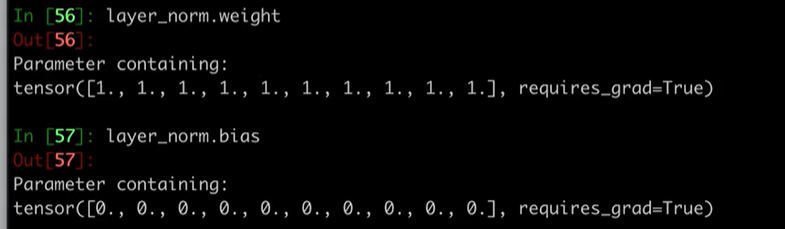


图像场景：
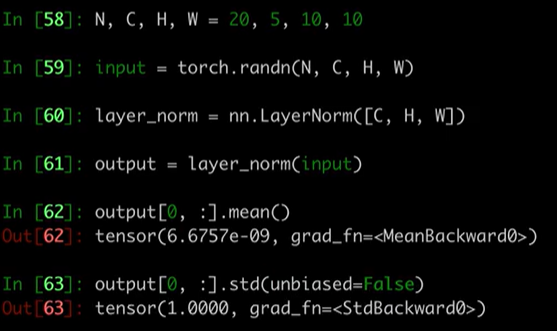
针对每个样本内部 C H W 进行归一化，即 last d>>[C,H,W]




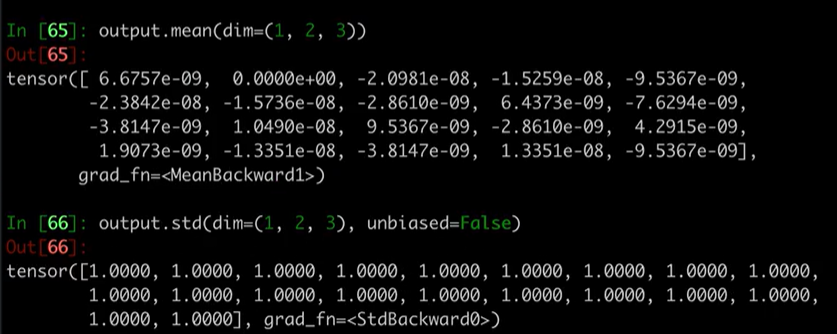
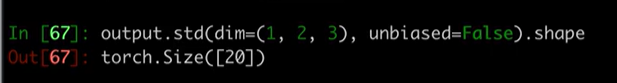
一共20个三维矩阵

沿着第 1、2、3 维一起做 reduce（求平均），把这几维都“压掉”
    output.shape == (N, C, H, W) == (20, 5, 10, 10)
    维度编号是：dim0=N，dim1=C，dim2=H，dim3=W
dim 指定要对哪些轴做归约（reduce）：把这些维度上的元素都拿来参与求平均
output.mean(dim=(1,2,3)) 等价于：对每个 n，把 output[n, :, :, :] 里 C×H×W 个数求平均
dim 指的是对哪些维度做聚合（求均值/求和/求最大等）


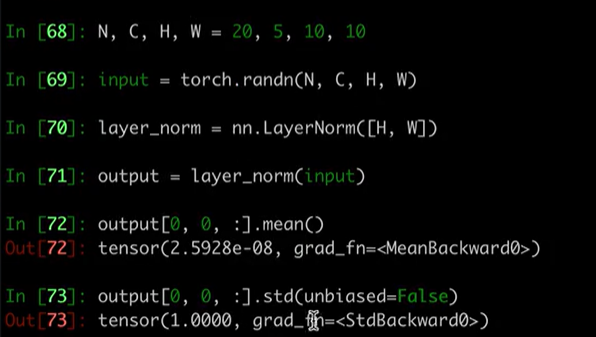
按照HW的维度去做LM，每个样本内的每个通道内部做归一化


验证，按照dim 2 3 取做reduce
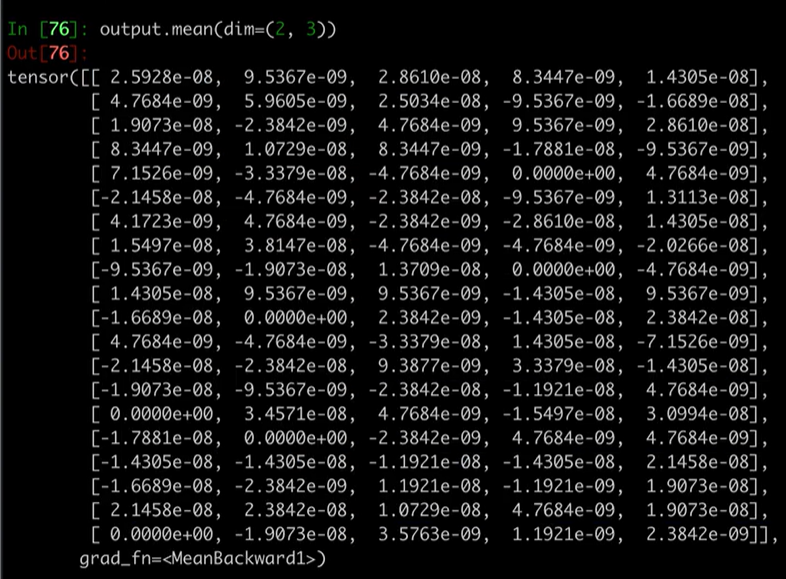
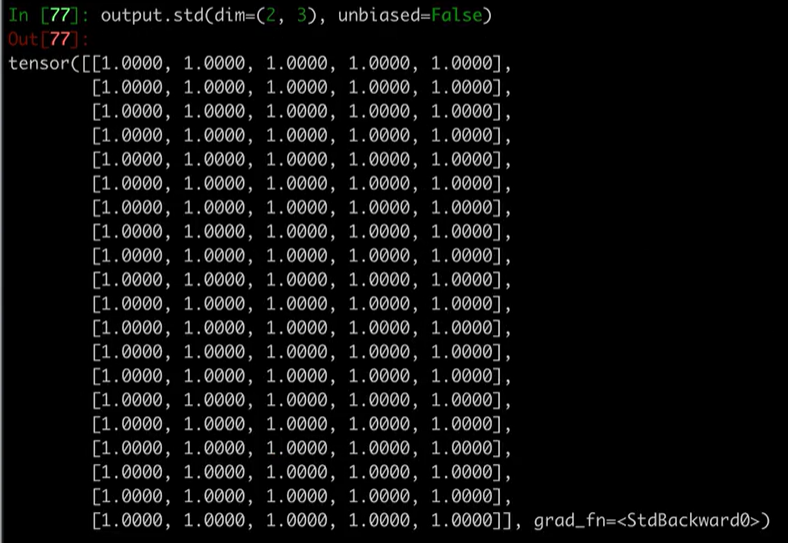

LM  接受指定一个shape，一个last D，以图像的例子，这个Dim 可以是 [C,H,W] 可以是[H,W],也可以是[W],但是不能跨batch做归一化， 0均值1标准差
